<a href="https://colab.research.google.com/github/himewel/covid19retail/blob/main/notebooks/forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/MyDrive/covid19-retail-090522-773462c5c6bd.json' 
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/drive/MyDrive/covid19-retail-090522-773462c5c6bd.json


In [ ]:
from google.cloud import bigquery

bqclient = bigquery.Client()

# Download query results.
query_string = """
    WITH reports_weekly AS (
        SELECT
            DATE_SUB(dates.DsDate, INTERVAL dates.NuDayOfWeek - 1 DAY) AS refDate,
            reports.CdCounty,
            SUM(reports.QtConfirmed) AS QtConfirmed,
            SUM(reports.QtDeceased) AS QtDeceased
        FROM `covid19-retail-090522.covid19retail_app.fact_reports` AS reports
            JOIN `covid19-retail-090522.covid19retail_app.dim_dates` AS dates
            ON dates.CdDate = reports.CdDate
        GROUP BY refDate, reports.CdCounty
    ),
    sales_weekly AS (
        SELECT
            DATE_SUB(dates.DsDate, INTERVAL dates.NuDayOfWeek - 1 DAY) AS refDate,
            stores.CdCounty,
            SUM(sales.QtBottlesSold) AS QtBottlesSold,
            SUM(sales.VrSalesDollars) AS VrSalesDollars
        FROM `covid19-retail-090522.covid19retail_app.fact_sales` AS sales
        JOIN `covid19-retail-090522.covid19retail_app.dim_dates` AS dates
            ON dates.CdDate = sales.CdDate
        JOIN `covid19-retail-090522.covid19retail_app.dim_stores` AS stores
            ON stores.CdStore = sales.CdStore
        GROUP BY refDate, stores.CdCounty
    ),
    stringency_weekly AS (
        SELECT
            DATE_SUB(dates.DsDate, INTERVAL dates.NuDayOfWeek - 1 DAY) AS refDate,
            AVG(events.InStringencyIndex) AS InStringencyIndex,
            AVG(InSchoolClosing) AS InSchoolClosing,
            AVG(InWorkspaceClosing) AS InWorkspaceClosing,
            AVG(InCancelPublicEvents) AS InCancelPublicEvents,
            AVG(InRestrictionsOnGatherings) AS InRestrictionsOnGatherings,
            AVG(InPublicTransportClosing) AS InPublicTransportClosing,
            AVG(InStayAtHomeRequirements) AS InStayAtHomeRequirements,
            AVG(InRestrictionsOnInternalMovement) AS InRestrictionsOnInternalMovement,
            AVG(InInternationalTravelControls) AS InInternationalTravelControls,
            AVG(InIncomeSupport) AS InIncomeSupport,
            AVG(InDebtRelief) AS InDebtRelief,
            AVG(InPublicInformationCampaigns) AS InPublicInformationCampaigns,
            AVG(InTestingPolicy) AS InTestingPolicy,
            AVG(InContactTracing) AS InContactTracing,
            AVG(InFacialCoverings) AS InFacialCoverings,
            AVG(InVaccinationPolicy) AS InVaccinationPolicy
        FROM `covid19-retail-090522.covid19retail_app.fact_events` AS events
        JOIN `covid19-retail-090522.covid19retail_app.dim_dates` AS dates
            ON dates.CdDate = events.CdDate
        GROUP BY refDate
    )

    SELECT
        reports_weekly.refDate,
        reports_weekly.CdCounty,
        reports_weekly.QtConfirmed,
        reports_weekly.QtDeceased,
        sales_weekly.QtBottlesSold,
        sales_weekly.VrSalesDollars,
        stringency_weekly.InStringencyIndex,
        stringency_weekly.InSchoolClosing,
        stringency_weekly.InWorkspaceClosing,
        stringency_weekly.InCancelPublicEvents,
        stringency_weekly.InRestrictionsOnGatherings,
        stringency_weekly.InPublicTransportClosing,
        stringency_weekly.InStayAtHomeRequirements,
        stringency_weekly.InRestrictionsOnInternalMovement,
        stringency_weekly.InInternationalTravelControls,
        stringency_weekly.InIncomeSupport,
        stringency_weekly.InDebtRelief,
        stringency_weekly.InPublicInformationCampaigns,
        stringency_weekly.InTestingPolicy,
        stringency_weekly.InContactTracing,
        stringency_weekly.InFacialCoverings,
        stringency_weekly.InVaccinationPolicy
    FROM reports_weekly
    LEFT JOIN sales_weekly
        ON sales_weekly.CdCounty = reports_weekly.CdCounty
        AND sales_weekly.refDate = reports_weekly.refDate
    LEFT JOIN stringency_weekly
        ON sales_weekly.refDate = stringency_weekly.refDate
"""

df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)
print(df.columns)

Index(['refDate', 'CdCounty', 'QtConfirmed', 'QtDeceased', 'QtBottlesSold',
       'VrSalesDollars', 'InStringencyIndex', 'InSchoolClosing',
       'InWorkspaceClosing', 'InCancelPublicEvents',
       'InRestrictionsOnGatherings', 'InPublicTransportClosing',
       'InStayAtHomeRequirements', 'InRestrictionsOnInternalMovement',
       'InInternationalTravelControls', 'InIncomeSupport', 'InDebtRelief',
       'InPublicInformationCampaigns', 'InTestingPolicy', 'InContactTracing',
       'InFacialCoverings', 'InVaccinationPolicy'],
      dtype='object')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

corr_matrix = df.set_index(["CdCounty", "refDate"])

with pd.option_context('display.precision', 2):
    style = corr_matrix.corr().style.background_gradient(cmap='coolwarm')
style

,QtConfirmed,QtDeceased,QtBottlesSold,VrSalesDollars,InStringencyIndex,InSchoolClosing,InWorkspaceClosing,InCancelPublicEvents,InRestrictionsOnGatherings,InPublicTransportClosing,InStayAtHomeRequirements,InRestrictionsOnInternalMovement,InInternationalTravelControls,InIncomeSupport,InDebtRelief,InPublicInformationCampaigns,InTestingPolicy,InContactTracing,InFacialCoverings,InVaccinationPolicy
QtConfirmed,1.00,0.57,0.56,0.56,0.02,0.03,-0.03,-0.08,0.00,-0.07,0.01,0.09,0.12,0.07,-0.03,0.09,0.14,-0.04,0.12,0.05
QtDeceased,0.57,1.00,0.52,0.51,0.10,0.09,0.05,0.01,0.07,-0.06,0.13,0.12,0.11,0.17,0.01,0.12,0.09,-0.02,0.19,-0.02
QtBottlesSold,0.56,0.52,1.00,1.00,0.01,0.01,0.00,0.01,-0.00,0.00,0.00,0.02,0.02,0.01,0.01,0.02,0.02,0.01,0.02,0.01
VrSalesDollars,0.56,0.51,1.00,1.00,0.01,0.00,-0.00,0.00,-0.01,-0.00,-0.00,0.03,0.03,0.01,0.00,0.03,0.03,0.01,0.02,0.02
InStringencyIndex,0.02,0.10,0.01,0.01,1.00,0.83,0.82,0.85,0.66,0.60,0.76,0.65,0.43,0.83,0.80,0.66,0.01,0.60,0.28,-0.39
InSchoolClosing,0.03,0.09,0.01,0.00,0.83,1.00,0.76,0.69,0.43,0.73,0.80,0.40,0.18,0.82,0.81,0.40,-0.13,0.69,0.22,-0.57
InWorkspaceClosing,-0.03,0.05,0.00,-0.00,0.82,0.76,1.00,0.81,0.60,0.53,0.87,0.24,0.01,0.71,0.82,0.25,-0.37,0.46,0.09,-0.74
InCancelPublicEvents,-0.08,0.01,0.01,0.00,0.85,0.69,0.81,1.00,0.65,0.50,0.71,0.34,0.02,0.62,0.85,0.34,-0.36,0.43,0.12,-0.52
InRestrictionsOnGatherings,0.00,0.07,-0.00,-0.01,0.66,0.43,0.60,0.65,1.00,0.41,0.41,0.11,0.01,0.31,0.44,0.12,-0.28,0.27,-0.27,-0.43
InPublicTransportClosing,-0.07,-0.06,0.00,-0.00,0.60,0.73,0.53,0.50,0.41,1.00,0.50,0.14,0.01,0.48,0.58,0.14,-0.16,0.86,-0.22,-0.48


In [ ]:
feature_columns = ['QtConfirmed', 'QtDeceased']
corr_matrix = corr_matrix[['QtBottlesSold'] + feature_columns].copy()

for column in feature_columns:
    corr_matrix[f"{column}Mean"] = corr_matrix[column].rolling(3).mean()
    corr_matrix[f"{column}Std"] = corr_matrix[column].rolling(3).std()

with pd.option_context('display.precision', 2):
    style = corr_matrix.corr().style.background_gradient(cmap='coolwarm')
style

,QtBottlesSold,QtConfirmed,QtDeceased,QtConfirmedMean,QtConfirmedStd,QtDeceasedMean,QtDeceasedStd
QtBottlesSold,1.00,0.56,0.52,0.36,0.28,0.34,0.30
QtConfirmed,0.56,1.00,0.57,0.70,0.60,0.43,0.39
QtDeceased,0.52,0.57,1.00,0.43,0.32,0.72,0.60
QtConfirmedMean,0.36,0.70,0.43,1.00,0.90,0.61,0.58
QtConfirmedStd,0.28,0.60,0.32,0.90,1.00,0.47,0.56
QtDeceasedMean,0.34,0.43,0.72,0.61,0.47,1.00,0.85
QtDeceasedStd,0.30,0.39,0.60,0.58,0.56,0.85,1.00


In [ ]:
# filtrando Polk County
data = corr_matrix.reset_index()
data = data.loc[data["CdCounty"] == 77]
data = data.set_index("refDate")
data = data.drop(["CdCounty"], axis=1)
data = data.sort_index()
print(data)

            QtBottlesSold  QtConfirmed  QtDeceased  QtConfirmedMean  \
refDate                                                               
2019-12-29        54188.0            0           0         0.000000   
2020-01-05       100486.0            0           0         0.000000   
2020-01-12        91360.0            0           0         0.000000   
2020-01-19       107176.0            0           0         0.000000   
2020-01-26       102410.0            0           0         0.000000   
...                   ...          ...         ...              ...   
2022-03-27       125052.0           65           6        23.333333   
2022-04-03       145983.0          151           4        52.666667   
2022-04-10       151559.0          154           3        54.000000   
2022-04-17       133507.0          210           7        70.000000   
2022-04-24       141322.0          285           3       101.000000   

            QtConfirmedStd  QtDeceasedMean  QtDeceasedStd  
refDate         

Train dates : 2019-12-29 --- 2021-07-18  (n=82)
Test dates  : 2021-07-25 --- 2022-04-24  (n=40)


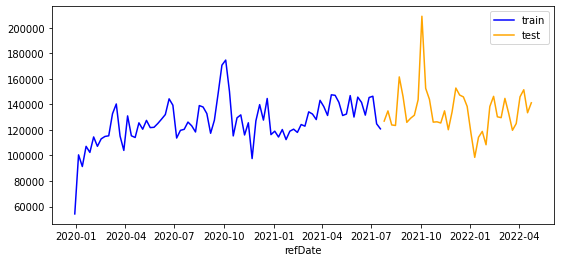

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from joblib import dump, load

steps = 40
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['QtBottlesSold'].plot(ax=ax, label='train', color="blue")
data_test['QtBottlesSold'].plot(ax=ax, label='test', color="orange")
ax.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

data_pred = data.copy()

regr = LinearRegression()
regr.fit(data_train.drop("QtBottlesSold", axis=1), data_train[["QtBottlesSold"]])
qtBottlesSold_pred = regr.predict(data_test.drop("QtBottlesSold", axis=1))

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(data_test[["QtBottlesSold"]], qtBottlesSold_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(data_test[["QtBottlesSold"]], qtBottlesSold_pred))

data_pred["LinearRegression"] = regr.predict(data.drop("QtBottlesSold", axis=1))

Coefficients: 
 [[ -38.33058247  -44.60141825   52.20354402   28.98159584 -235.93878173
   522.32509287]]
Mean squared error: 483039162.03
Coefficient of determination: -0.56


In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=5, max_depth=7, random_state=1, bootstrap=False)
regr.fit(data_train.drop("QtBottlesSold", axis=1), data_train[["QtBottlesSold"]])
qtBottlesSold_pred = regr.predict(data_test.drop("QtBottlesSold", axis=1))

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(data_test[["QtBottlesSold"]], qtBottlesSold_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(data_test[["QtBottlesSold"]], qtBottlesSold_pred))

data_pred["RandomForestRegressor"] = regr.predict(data.drop("QtBottlesSold", axis=1))

Mean squared error: 326745726.26
Coefficient of determination: -0.05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


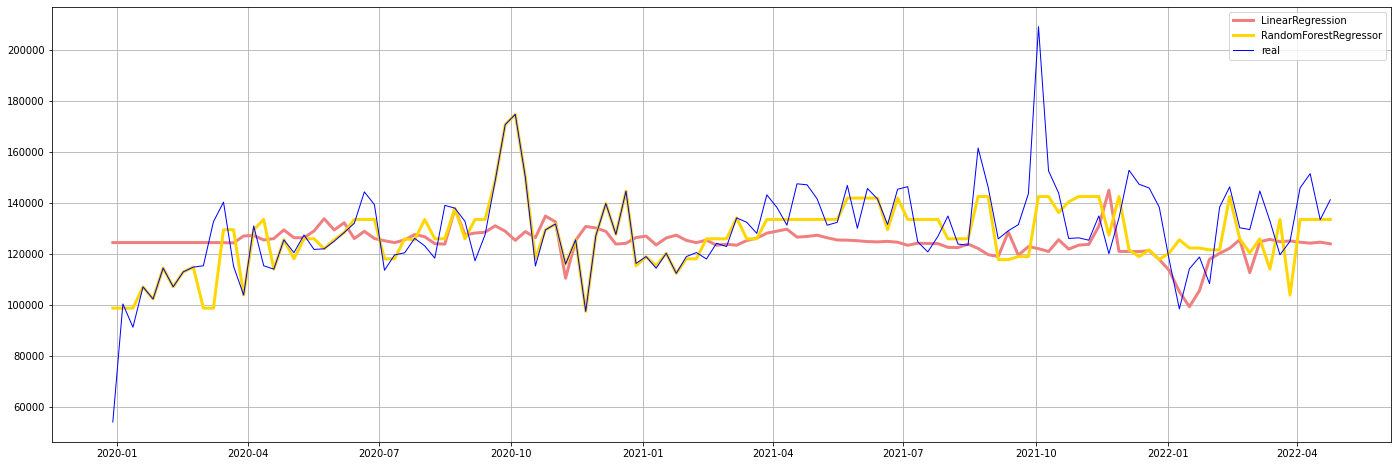

In [ ]:
plt.subplots(figsize=(24, 8))
plt_data = data_pred.reset_index()
plt.plot(plt_data[["refDate"]], plt_data[['LinearRegression']], label='LinearRegression', color="lightcoral", linewidth=3)
plt.plot(plt_data[["refDate"]], plt_data[['RandomForestRegressor']], label='RandomForestRegressor', color="gold", linewidth=3)
plt.plot(plt_data[["refDate"]], plt_data[['QtBottlesSold']], label='real', color="blue", linewidth=1)
plt.legend()
plt.grid()
plt.show()